# 2: Spherical wind
-------------------


In [1]:
import numpy             as np
import scipy             as sp
import matplotlib.pyplot as plt
import magritte.tools    as tools
import magritte.setup    as setup
import magritte.core     as magritte

from astropy import units, constants

In [2]:
# Deifne names for the data files
model_file = 'output/magritte_spherical_wind.hdf5'
lamda_file = 'data/co.txt'

If necessary, download the line data file form the [LAMDA database](https://home.strw.leidenuniv.nl/~moldata/).

In [3]:
!wget "https://home.strw.leidenuniv.nl/~moldata/datafiles/co.dat" --output-document $lamda_file

--2024-03-01 14:56:16--  https://home.strw.leidenuniv.nl/~moldata/datafiles/co.dat
Resolving home.strw.leidenuniv.nl (home.strw.leidenuniv.nl)... 132.229.214.179
Connecting to home.strw.leidenuniv.nl (home.strw.leidenuniv.nl)|132.229.214.179|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 444204 (434K)
Saving to: ‘data/co_cut_12.txt’

data/co_cut_12.txt  100%[===================>] 433.79K  1.11MB/s    in 0.4s    

2024-03-01 14:56:17 (1.11 MB/s) - ‘data/co_cut_12.txt’ saved [444204/444204]



You will modify two parameters to find the best fit model: the mass-loss rate and the power-law exponent of the temperature profile

In [4]:
# Define the mass-loss rate (Mdot) and temperature profile exponent (epsilon)
Mdot     = (5.0e-5  * units.M_sun/units.yr).si.value
epsilon  =  0.5

In [5]:
# Now define the other parameters we will need
distance = (740     * units.pc            ).si.value  # distance to WX Psc
r_star   = (520     * constants.R_sun     ).si.value  # stellar radius
r_in     =  1.7     * r_star                          # radius of the inner edge of the circumstellar envelope
r_out    = (1.1e+17 * units.cm            ).si.value  # radius of the outer edge of the circumstellar envelope
v_inf    = (19.8    * units.km/units.s    ).si.value  # expansion velocity of the envelope
T_star   = (2750    * units.K             ).si.value  # effective temperature of the star
T_in     = (1000    * units.K             ).si.value  # temperature at r_in = dust condensation temperature
xCO      =  1.0e-4                                    # fractional CO abundance (relative to H2)
v_turb   = (1.5e+0  * units.km   /units.s ).si.value  # turbulent velocity

# Define the number and array of radial points
npoints  = 512
rs = np.logspace(np.log10(r_in), np.log10(r_out), npoints, dtype=np.float64)

# Define the other arrays
v_r = v_inf  * np.ones_like(rs)                 # expansion velocity
trb = v_turb * np.ones_like(rs)                 # turbulent velocity
tmp = T_in * (r_in / rs)**epsilon             # temperature
rho = Mdot / (4.0 * np.pi * rs**2 * v_r)        # density
nH2 = (constants.N_A.si.value / 2.02e-3) * rho  # H2 density
nCO = xCO * nH2                                 # CO density

In [202]:
# Set up a spherically symmetric Magritte model with the parameters defined above
model = magritte.Model ()
model.parameters.set_spherical_symmetry(True)
model.parameters.set_model_name        (model_file)
model.parameters.set_dimension         (1)
model.parameters.set_npoints           (npoints)
model.parameters.set_nrays             (48)
model.parameters.set_nspecs            (3)
model.parameters.set_nlspecs           (1)
model.parameters.set_nquads            (11)
model.parameters.pop_prec              =1e-4

model.geometry.points.position.set([[r,                      0, 0] for r in rs])
model.geometry.points.velocity.set([[v/constants.c.si.value, 0, 0] for v in v_r])

model.chemistry.species.abundance = [[CO, H2, 0.0] for (CO, H2) in zip(nCO, nH2)]
model.chemistry.species.symbol    = ['CO', 'H2', 'e-']

model.thermodynamics.temperature.gas  .set( tmp                         )
model.thermodynamics.turbulence.vturb2.set((trb/constants.c.si.value)**2)

model = setup.set_Delaunay_neighbor_lists (model)
model = setup.set_Delaunay_boundary       (model)
model = setup.set_boundary_condition_CMB  (model)
model = setup.set_rays_spherical_symmetry (model)
model = setup.set_linedata_from_LAMDA_file(model, lamda_file)
model = setup.set_quadrature              (model)

# Write and read model to initialize all variables
model.write()
model.read ()

Writing parameters...
Writing points...
Writing rays...
Writing boundary...
Writing chemistry...
Writing species...
Writing thermodynamics...
Writing temperature...
Writing turbulence...
Writing lines...
Writing lineProducingSpecies...
Writing linedata...
ncolpoar = 2
--- colpoar = 0
Writing collisionPartner...
(l, c) = 0, 0
--- colpoar = 1
Writing collisionPartner...
(l, c) = 0, 1
Writing quadrature...
Writing populations...
Writing radiation...
Writing frequencies...
                                           
-------------------------------------------
  Reading Model...                         
-------------------------------------------
 model file = output/magritte_spherical_wind.hdf5
-------------------------------------------
Reading parameters...
Reading points...
Reading rays...
Reading boundary...
Reading chemistry...
Reading species...
Reading thermodynamics...
Reading temperature...
Reading turbulence...
Reading lines...
Reading lineProducingSpecies...
Reading linedata...


In [203]:
# Initialize model with LTE level populations
model.compute_spectral_discretisation ()
model.compute_inverse_line_widths     ()
model.compute_LTE_level_populations   ()

Computing spectral discretisation...
Computing inverse line widths...
Computing LTE level populations...


0

In [204]:
# Iterate level populations until statistical equilibrium
model.compute_level_populations_sparse (True, 200)

using ng acceleration? 0
Starting iteration 1
Computing the radiation field...
Computing radiation field...

7


--- rr = 0
--- rr = 1
--- rr = 2
--- rr = 3
--- rr = 4
--- rr = 5
--- rr = 6
--- rr = 7
--- rr = 8
--- rr = 9
--- rr = 10
--- rr = 11
--- rr = 12
--- rr = 13
--- rr = 14
--- rr = 15
--- rr = 16
--- rr = 17
--- rr = 18
--- rr = 19
--- rr = 20
--- rr = 21
--- rr = 22
--- rr = 23
Tot | Compute Radiation Field : 18.438404 seconds
Minor warning: population inversions detected; Magritte does not handle masers, so setting affected populations to LTE.
Tot | Compute Statistical Equilibrium : 0.018644 seconds
Already 32.6172 % converged!
using ng acceleration? 0
Starting iteration 2
Computing the radiation field...
Computing radiation field...
--- rr = 0
--- rr = 1
--- rr = 2
--- rr = 3
--- rr = 4
--- rr = 5
--- rr = 6
--- rr = 7
--- rr = 8
--- rr = 9
--- rr = 10
--- rr = 11
--- rr = 12
--- rr = 13
--- rr = 14
--- rr = 15
--- rr = 16
--- rr = 17
--- rr = 18
--- rr = 19
--- rr = 20
--- rr = 21
--- rr = 22
--- rr = 23
Tot | Compute Radiation Field : 37.481906 seconds
Minor warning: population inv

In [205]:
# Now plot the output model spectra against the data (***currently in Tmb (K) but can be converted to Jy if that's easier!), and calculate the chi2 value for goodness of fit

In [206]:
line_nr = 2 # CO (J=3-2)
# line_nr = 3 # CO (J=4-3)
# line_nr = 6 # CO (J=7-6)

In [207]:
nfreqs = 256
vpix   = 400.0   # velocity pixel size [m/s]
fcen = model.lines.lineProducingSpecies[0].linedata.frequency[line_nr]
dd   = vpix * (nfreqs-1)/2 / magritte.CC
fmin = fcen - fcen*dd
fmax = fcen + fcen*dd

model.compute_spectral_discretisation(fmin, fmax, nfreqs)
model.compute_image(model.parameters.hnrays()-1)

Computing spectral discretisation...


0

Computing image...


In [208]:
@units.quantity_input(angle='angle', distance='length')
def convert_angular_to_spatial(angle, distance):
    """
    Convert angles to distances assuming a certain distance.
    """
    angle    = angle   .to(units.arcsec).value
    distance = distance.to(units.pc    ).value
    return angle * distance * units.au

In [209]:
dist =  740 * units.pc       # distance tot the object
FWHM = 17.3 * units.arcsec   # FWHM of the beam

# Extract the image data from Magritte
image_nr = -1
imx = np.array(model.images[image_nr].ImX)
imI = np.array(model.images[image_nr].I)

# Calculate integration weights (converting to Jansky)
b  = imx # impact factors
b0 = np.concatenate(([0.0], b))
ds = np.pi * (b0[1:] - b0[:-1]) * (b0[1:] + b0[:-1]) / dist.si.value**2 / 1.0e-26

# Calculate beam
FWHM_m = convert_angular_to_spatial(angle=FWHM, distance=dist).si.value
sigma  = FWHM_m / (2.0 * np.sqrt(2.0 * np.log(2)))
beam   = np.exp(-0.5*(b/sigma)**2) / (np.sqrt(2.0 * np.pi) * sigma)
beam   = beam / beam[0]   # Is this what we want?

I_no_beam  = np.einsum('if, i -> f', imI,        ds)
I          = np.einsum('if, i -> f', imI, beam * ds)

In [210]:
freqs = np.array(model.radiation.frequencies.nu)[0]
velos = (freqs - fcen) / fcen * magritte.CC / 1.0e3

In [211]:
velo, flux_density = np.loadtxt('data/WX_Psc_CO32_Jy.dat', unpack=True)

In [212]:
v_rad = 9.0
mask = np.logical_and(velo > -42.0, velo < 60.0)

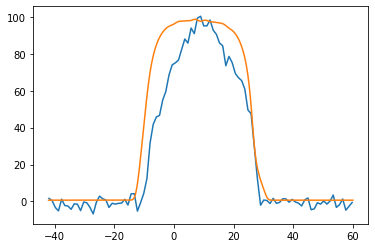

In [213]:
plt.plot(velo[mask], flux_density[mask])
plt.plot(velos+v_rad, I)